# Mask R-CNN - Train on Fashion Dataset


This notebook shows how to train Mask R-CNN on the Fashion dataset. 

The code of the *Fashion* dataset is included below. A maskrcnn.utils.DataSet object is customized for the Fashion dataset.  This object is used to train the model.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log



%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    

Using TensorFlow backend.


In [2]:
# !pip install ipywidgets 
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

# %%capture
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import skimage
import random

from pycocotools.coco import maskUtils


## Configurations

In [3]:
class FashionConfig(Config):
    """
    Configuration for training on the fashion dataset.
    Derives from the base Config class and overrides values specific
    to the fashion dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #can change this

    # Number of classes (including background)
    NUM_CLASSES = 1 + 46  # background + 46 fashion categories
    
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
import pickle

# Use pickle to save history for later use
def pickle_save(variable, save_dir, pickel_fileName):
#     cwd = os.getcwd()
#     Save_dir = cwd + '//pickle//'
    save_file = save_dir + pickel_fileName
    if os.path.isdir(save_dir) == 0:
        os.mkdir(save_dir)
    with open(save_file, 'wb') as f:
        pickle.dump(variable, f)


# Loading a prevously saved pickle file
def pickle_load(save_dir, pickel_fileName):
#     cwd = os.getcwd()
#     pickle_file = cwd + '//pickle//' + pickel_fileName
    # Getting back the data:
    pickle_filepath = os.path.join(save_dir, pickel_fileName)
    with open(pickle_filepath, 'rb') as f:
        history = pickle.load(f)
        return history

## Dataset

Create a dataset object to use with Mask_RCNN. <br>
https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

in the COCO object, image_info is a dictionary with keys:<br>
    image_info = {'info':info, <br>
                  'licenses':licenses, <br>
                  'images':images,<br>
                  'annotations':annotations,<br>
                  'categories':categories}<br>
                  
Dataset Methods: <br>
#### Bounding Boxes
- extract_bboxes(mask)
- compute_iou(box, boxes, box_area, boxes_area)
- compute_overlaps(boxes1, boxes2)
- compute_overlaps_masks(masks1, masks2)
- non_max_suppression(boxes, scores, threshold)
- apply_box_deltas(boxes, deltas)
- box_refinement_graph(box, gt_box)
- box_refinement(box, gt_box)

#### Dataset Class
- class Dataset(object):
- __init__(self, class_map=None)
- def add_class(self, source, class_id, class_name)
- add_image(self, source, image_id, path, **kwargs)
- image_reference(self, image_id)
- prepare(self, class_map=None)
- map_source_class_id(self, source_class_id)
- get_source_class_id(self, class_id, source)
- @property image_ids(self)
- source_image_link(self, image_id)
- load_image(self, image_id)
- load_mask(self, image_id)
- resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square")
- resize_mask(mask, scale, padding, crop=None)
- minimize_mask(bbox, mask, mini_shape)
- expand_mask(bbox, mini_mask, image_shape)
- unmold_mask(mask, bbox, image_shape)

#### Anchors
- generate_anchors(scales, ratios, shape, feature_stride, anchor_stride)
- generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,anchor_stride)

#### Miscellaneous
- trim_zeros(x)
- compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0)
- compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5)
- compute_ap_range(gt_box, gt_class_id, gt_mask,
                     pred_box, pred_class_id, pred_score, pred_mask,
                     iou_thresholds=None, verbose=1)
- compute_recall(pred_boxes, gt_boxes, iou)


#### Batch Slicing
- batch_slice(inputs, graph_fn, batch_size, names=None)
- download_trained_weights(coco_model_path, verbose=1)
- norm_boxes(boxes, shape)
- denorm_boxes(boxes, shape)
- resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None)



In [6]:

# Init for utils.Dataset
# def __init__(self, class_map=None):
#         self._image_ids = []  # initialized during prepare()
#         self.image_info = []  # populated with add_image() - see below
#         # Background is always the first class
#         self.class_info = [{"source": "", "id": 0, "name": "BG"}] # populated with add_class() - see below
#         self.source_class_ids = {} # initialized during prepare()

In [7]:
# def add_class(self, source, class_id, class_name):
#         assert "." not in source, "Source name cannot contain a dot"
#         # Does the class exist already?
#         for info in self.class_info:
#             if info['source'] == source and info["id"] == class_id:
#                 # source.class_id combination already available, skip
#                 return
#         # Add the class
#         self.class_info.append({
#             "source": source,
#             "id": class_id,
#             "name": class_name,
#         })

In [8]:
# def add_image(self, source, image_id, path, **kwargs):
#         image_info = {
#             "id": image_id,
#             "source": source,  # this is 'fashion'  for coco is is 'coco'
#             "path": path,
#         }
#         image_info.update(kwargs)
#         self.image_info.append(image_info)

## Build the FashionDataset object -- based on the CocoDataset Object

After instantiating a new instance of FashionDataset:
- 1) add method to create classes: create_classes(self, cat_file:str)
- 2) Add image info with add_image()
- 3) implement image_reference()
- 4) implement load_image()


In [9]:
data_dir    = '../../data/FashionDataSet/'
train_dir   = os.path.join(data_dir, 'train')
images_file = os.path.join(data_dir, 'train.csv' )
cat_file    = os.path.join(data_dir, 'label_descriptions.json' )

In [10]:
np.array([1,2])

array([1, 2])

In [11]:
class FashionDataset(utils.Dataset):
    
    def create_classes(self, cat_file:str) -> [dict]:
        """
        Added to FashionDataset.
        Initialize the classes.
        param:cat_file - filepath to fashion dataset's label_descriptions.json file
        """
        # read labels file
        with open(cat_file, 'r') as data_file:
            data=data_file.read()

        # parse file
        labels = json.loads(data)

        categories = labels.get('categories')
        df_categories = pd.DataFrame(categories)
        df_categories['source'] = "imaterialist"

        dict_categories = [dict(x[1]) for x in df_categories.iterrows()]

        for c in tqdm(dict_categories, desc="Adding classes"):
            self.add_class(c['source'], c['id'], c['name'])

        print ("{} classes added.".format(len(dict_categories)))

        return dict_categories
    
    
    def create_anns(self, sub_df_images:pd.DataFrame) -> dict:
        """
        Creates an 'annotations' entry in an image's image_info entry.
        dict_keys(['id', 'image_id', 'segmentation', 'category_id', 'area', 'iscrowd', 'bbox']
        """
        annotations = []
        
        for mask in sub_df_images.iterrows():
            h      = int(mask[1].get('height'))
            w      = int(mask[1].get('width'))
            counts = [int(x) for x in mask[1]['EncodedPixels'].split(' ')]
            
            ann_dict = {'id'            : mask[1]['id'] , 
                        'image_id'      : mask[1]['file_name'] , 
                        'segmentation'  : {'counts' : counts, 'size': [h, w] }, 
                        'category_id'   : int(mask[1]['ClassId'].split('_')[0]), 
#                         'area'          : 0, 
                        'iscrowd'       : True, # True indicates the use of uncompressed RLE
                        'bbox'          : [] }

            annotations.append(ann_dict)
            
        return annotations
        
    
    def create_images(self, images_file:str, train_dir:str) -> (dict, pd.DataFrame):
        """
        Build the image_info['images'] dictionary element with all images
        """
        
        # TESTING - LIMIT TO 1000 entries
        limit = 1000
#         count = 0
        # ###############################
        
        df_images = pd.read_csv(images_file, nrows=limit)
#         df_images = df_images.drop(['EncodedPixels', 'ClassId'], axis=1).drop_duplicates()
        df_images.rename(columns={"ImageId":'file_name', "Height":'height', "Width":'width'}, inplace=True)
        df_images['id'] = [x for x in range(len(df_images))]
        df_images['source'] = 'imaterialist'

        dict_images = [dict(x[1]) for x in tqdm(df_images.iterrows(), desc="Create images dict", total=len(df_images))]
        

        for image in tqdm(dict_images, desc="Add images to object"):
            self.add_image(source       = image['source'], 
                           image_id     = image['id'],
                           path         = os.path.join(train_dir,image['file_name']), 
                           height       = image['height'],
                           width        = image['width'],
                           file_name    = image['file_name'],
                           annotations  = self.create_anns(df_images[df_images.file_name==image['file_name']]))
            
#             # TESTING - LIMIT TO 1000 entries
#             count += 1
#             if count >= limit:
#                 break
#             # ###############################

        print("Added {} images.".format(len(df_images)))

        return self.image_info
    
    
    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
    
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        image_info = self.image_info[image_id]

        instance_masks = []
        class_ids = []
        
        # returns list of masks/annotations for the image
        annotations = self.image_info[image_id]["annotations"] 
        
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id'] # one of 46 categories
            
            if class_id:
                # passes an element of the annotations list - this is a single mask entry
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        # assume user provided the integer id of the image
        for img in self.image_info:
            if img['id'] == image_id:
                return img['path']

        # check if the user entered the file name
        for img in self.image_info:
            if img['file_name'] == image_id:
                return img['path']
        
        print ("Image '{}' not found.".format(image_id))
        return None

    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation'] # single masks segmentations details; count and size
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [12]:
fash = FashionDataset()
classes = fash.create_classes(cat_file) # takes seconds

image_info = fash.create_images(images_file, train_dir) # takes an hour


46 classes added.


5214 3676


SystemExit: 0

In [12]:
fash.image_reference(image_info[4]['file_name'])

'../../data/FashionDataSet/train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg'

In [13]:
image_info[5].keys()

dict_keys(['id', 'source', 'path', 'height', 'width', 'file_name', 'annotations'])

In [14]:
image_info[5].get('annotations')[0].get('segmentation').keys()

dict_keys(['counts', 'size'])

In [15]:
image_info[5].get('annotations')[0].get('segmentation').get("size")

[5214, 3676]

In [16]:
len(image_info[5]["annotations"])

9

In [17]:
annotation = image_info[5]["annotations"][0]

In [18]:
type(annotation.get('segmentation'))

dict

In [19]:
type(annotation.get('segmentation').get('counts'))

list

In [20]:
annotation.get('segmentation').get('counts')[0:10]

[6068157, 7, 6073371, 20, 6078584, 34, 6083797, 48, 6089010, 62]

In [ ]:
m = fash.annToMask(annotation, image_info[5]["height"], image_info[5]["width"])

In [17]:
image_info[5]['id']

5

In [ ]:
fash.load_mask(5)

In [75]:
pickle_save(fash, data_dir, 'fashion_dataset.pkl')

In [13]:
fash = pickle_load(data_dir, 'fashion_dataset.pkl')

In [15]:
maskUtils.frPyObjects(segm, height, width)

NameError: name 'segm' is not defined

In [40]:
df_images.iloc[0]['file_name']

'00000663ed1ff0c4e0132b9b9ac53f6e.jpg'

In [23]:
df_images[df_images.file_name=='00000663ed1ff0c4e0132b9b9ac53f6e.jpg']

,file_name,height,width,id,source
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,0,imaterialist


In [14]:
fash.image_info[0]

{'id': 0,
 'source': 'imaterialist',
 'path': '../../data/FashionDataSet/train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg',
 'height': 5214,
 'width': 3676,
 'file_name': '00000663ed1ff0c4e0132b9b9ac53f6e.jpg'}

In [15]:
fash.image_reference('00000663ed1ff0c4e0132b9b9ac53f6e.jpg')

0

In [16]:
df_images.head()

,file_name,height,width,id,source
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,0,imaterialist
9,0000fe7c9191fba733c8a69cfaf962b7.jpg,2448,2448,1,imaterialist
11,0002ec21ddb8477e98b2cbb87ea2e269.jpg,3000,1997,2,imaterialist
15,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,567,400,3,imaterialist
18,0004467156e47b0eb6de4aa6479cbd15.jpg,750,500,4,imaterialist


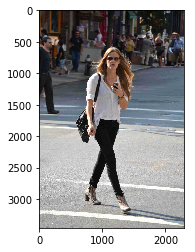

In [57]:
rndint = random.randint(0,45625)
plt.imshow(fash.load_image(rndint));

In [58]:
plt.imshow(fash.load_mask(rndint));

TypeError: an integer is required

In [8]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

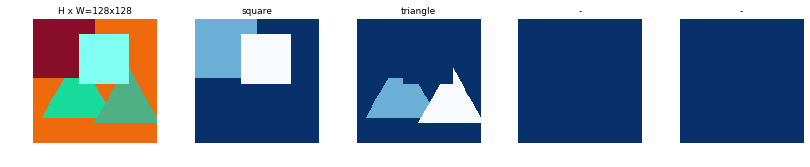

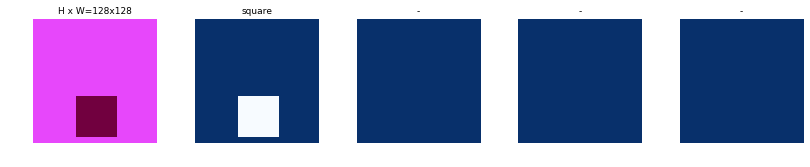

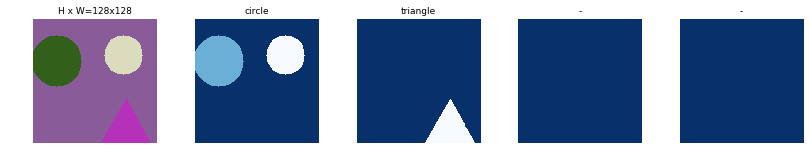

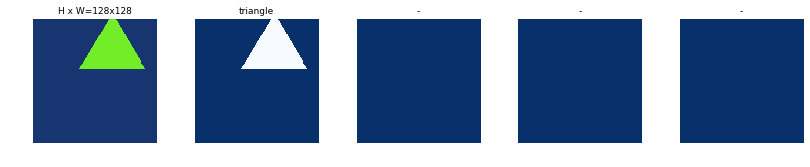

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [16]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [17]:
dataset_train

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [18]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/markmcdonald/Library/Mobile Documents/com~apple~CloudDocs/Harvard/CSCI_E25/Project/libraries/Mask_RCNN/logs/shapes20191105T1103/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcn

In [19]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/markmcdonald/Library/Mobile Documents/com~apple~CloudDocs/Harvard/CSCI_E25/Project/libraries/Mask_RCNN/logs/shapes20191105T1103/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a      

Epoch 2/2
100/100 [==============================] - 1778s 18s/step - loss: 0.9600 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4202 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2480 - val_loss: 0.9723 - val_rpn_class_loss: 0.0169 - val_rpn_bbox_loss: 0.4511 - val_mrcnn_class_loss: 0.1437 - val_mrcnn_bbox_loss: 0.1419 - val_mrcnn_mask_loss: 0.2187


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (128, 128, 3)         min:  108.00000  max:  236.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_bbox                  shape: (2, 5)                min:    2.00000  max:  102.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000


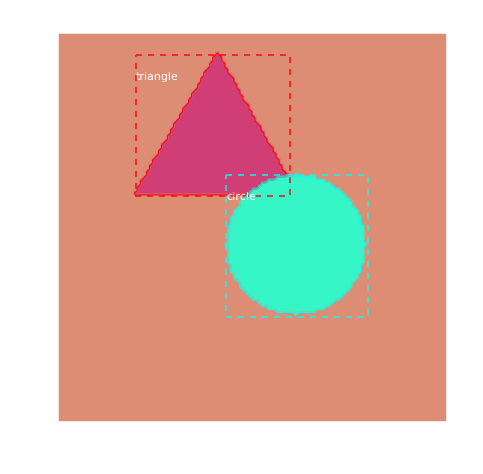

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


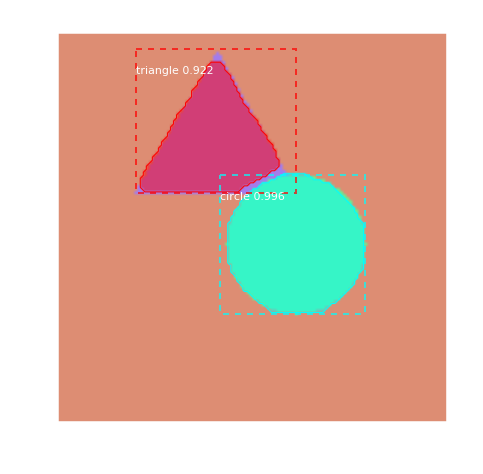

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
